# Data Transform

In this notebook, we will ask you a series of questions to evaluate your findings from your EDA. Based on your response & justification, we will ask you to also apply a subsequent data transformation. 

If you state that you will not apply any data transformations for this step, you must **justify** as to why your dataset/machine-learning does not require the mentioned data preprocessing step.

The bonus step is completely optional, but if you provide a sufficient feature engineering step in this project we will add `1000` points to your Kahoot leaderboard score.

You will write out this transformed dataframe as a `.csv` file to your `data/` folder.

**Note**: Again, note that this dataset is quite large. If you find that some data operations take too long to complete on your machine, simply use the `sample()` method to transform a subset of your data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [15]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
transactions = pd.read_csv(r"C:\Users\tosth\OneDrive\Documents\detect-fraud\data\bank_transactions.csv")
scaler = MinMaxScaler()
transactions['log_amount'] = np.log1p(transactions['amount']) 


In [16]:
print(transactions.columns)

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'log_amount'],
      dtype='object')


## Q1

Does your model contain any missing values or "non-predictive" columns? If so, which adjustments should you take to ensure that your model has good predictive capabilities? Apply your data transformations (if any) in the code-block below.

ANSWER
The model does contain missing values and non-predictive columns. I first replaces missing values with statistical values of median seeing as how we have a large data set with outliers frome the data making the use of mean less effective statistical value. I used  Min-Max Scaling to transform numeric features to a fixed range.

In [17]:
# Drop non-predictive column
transactions = transactions.drop(columns=['transaction_id'], errors='ignore')

In [23]:
print(transactions.head())

       type      amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0   PAYMENT      983.09  C1454812978       36730.24        35747.15   
1   PAYMENT    55215.25  C1031766358       99414.00        44198.75   
2   CASH_IN   220986.01  C1451868666     7773074.97      7994060.98   
3  TRANSFER  2357394.75   C458368123           0.00            0.00   
4  CASH_OUT    67990.14  C1098978063           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1491308340            0.00            0.00        0               0   
1  M2102868029            0.00            0.00        0               0   
2  C1339195526       924031.48       703045.48        0               0   
3   C620979654      4202580.45      6559975.19        0               0   
4   C142246322       625317.04       693307.19        0               0   

   log_amount  
0    6.891717  
1   10.919013  
2   12.305859  
3   14.673068  
4   11.127133  


In [ ]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
numeric_cols = ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'log_amount']  
transactions[numeric_cols] = imputer.fit_transform(transactions[numeric_cols])

In [ ]:
print(transactions.columns.tolist())

['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud', 'log_amount']


In [25]:
imputer = SimpleImputer(strategy='median')
transactions[numeric_cols] = imputer.fit_transform(transactions[numeric_cols])

In [28]:
scaler = MinMaxScaler()
transactions[['AmountScaled', 'BalanceScaled']] = scaler.fit_transform(
    transactions[['amount', 'newbalanceDest']]
)

In [29]:
print(transactions.columns)

Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'log_amount', 'AmountScaled', 'BalanceScaled'],
      dtype='object')


## Q2

Do certain transaction types consistently differ in amount or fraud likelihood? If so, how might you transform the type column to make this pattern usable by a machine learning model? Apply your data transformations (if any) in the code-block below.

Answer
Transfer have the highest fraud rate, significantly above others. Cash out is second, but still much lower. Cash in, Debit, and Payment have no fraud cases. You would transform the data by grouping all the rows in your dataset by the type of transaction and selecting column the that indicates 'isFraud'. Then you calculates the average fraud value for each group.'isFraud' is a binary column and the mean gives you the fraud rate the proportion of transactions that were fraud for each transaction type. We then group the data by type. Then it selects the amount column. We calculates the average transaction amount for each type using .mean(). we then have a print out of each type that is fraudulent and what the average dollar amount is for each type.



In [35]:
# Fraud rate by transaction type
fraud_by_type = transactions.groupby('type')['isFraud'].mean()

# Average amount by transaction type
amount_by_type = transactions.groupby('type')['amount'].mean()

print("Fraud Rate by Type:\n", fraud_by_type)
print("\nAverage Amount by Type:\n", amount_by_type)

Fraud Rate by Type:
 type
CASH_IN     0.000000
CASH_OUT    0.001870
DEBIT       0.000000
PAYMENT     0.000000
TRANSFER    0.007647
Name: isFraud, dtype: float64

Average Amount by Type:
 type
CASH_IN     168928.914668
CASH_OUT    175584.659320
DEBIT         5445.890813
PAYMENT      13055.592085
TRANSFER    911827.155179
Name: amount, dtype: float64


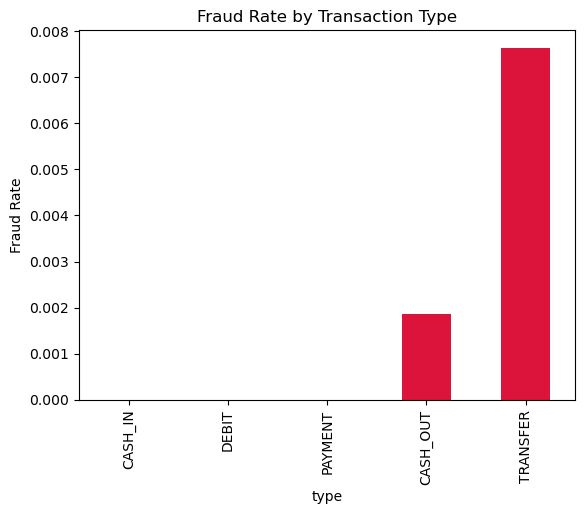

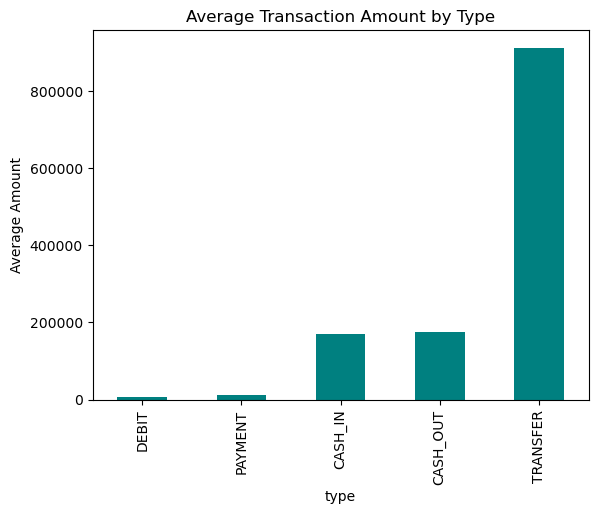

In [40]:
# Fraud rate plot
fraud_rate = transactions.groupby('type')['isFraud'].mean().sort_values()
fraud_rate.plot(kind='bar', title='Fraud Rate by Transaction Type', color='crimson')
plt.ylabel('Fraud Rate')
plt.show()

# Avg amount plot
avg_amount = transactions.groupby('type')['amount'].mean().sort_values()
avg_amount.plot(kind='bar', title='Average Transaction Amount by Type', color='teal')
plt.ylabel('Average Amount')
plt.show()

In [37]:
transactions_encoded = pd.get_dummies(transactions, columns=['type'], drop_first=True)


## Q3

After exploring your data, you may have noticed that fraudulent transactions are rare compared to non-fraudulent ones. What challenges might this pose when training a machine learning model? What strategies could you use to ensure your model learns meaningful patterns from the minority class? Apply your data transformations (if any) in the code-block below.

Answer
fraud detection datasets are flawed. The number of non-fraudulent transactions outnumber the amount of fraudulent ones. This causes issues in the machine learning model because due to the dataset being biased. It could predict many things as not fraud even though there may be some fraud.It may also miss fraud because it has  very few examples of fraud within its data. Strategies you can use to ensure the model learns meaningful patterns from the minority class is Oversampling the minority class and undersampling the majority class. You can also do a class weight adustment and possibly implemrnting an Anomaly Detection algorithm.


In [43]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [49]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# One-hot encode the 'type' column
transactions_encoded = pd.get_dummies(transactions, columns=['type'], drop_first=True)

# Define features (remove nameOrig, nameDest, and isFraud from features)
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
            'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
            'log_amount', 'AmountScaled', 'BalanceScaled'] + \
            [col for col in transactions_encoded.columns if col.startswith('type_')]

X = transactions_encoded[features]
y = transactions_encoded['isFraud']

# Scale the numeric features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split before SMOTE to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.3, random_state=42)

# Apply SMOTE to training data only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now you can feed X_train_resampled and y_train_resampled into your model
print("Original training set class distribution:\n", y_train.value_counts())
print("Resampled training set class distribution:\n", pd.Series(y_train_resampled).value_counts())


Original training set class distribution:
 isFraud
0    699092
1       908
Name: count, dtype: int64
Resampled training set class distribution:
 isFraud
0    699092
1    699092
Name: count, dtype: int64


In [50]:
print(transactions.columns)


Index(['type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud', 'log_amount', 'AmountScaled', 'BalanceScaled'],
      dtype='object')


## Bonus (optional)

Are there interaction effects between variables (e.g., fraud and high amount and transaction type) that aren't captured directly in the dataset? Would it be helpful to manually engineer any new features that reflect these interactions? Apply your data transformations (if any) in the code-block below.

Answer Here

In [2]:
# write out newly transformed dataset to your folder
...